<a href="https://colab.research.google.com/github/babazeedy/math-for-machine-learning/blob/main/Copy_of_GWP2_QUESTION_2_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Satellite Data User Guide**

## **Introduction**

This user guide will focus on Satellite data, a critical and rapidly expanding category of alternative data used in modern financial analysis. This data provides granular, near-real-time visibility into physical economic activity that is inaccessible through traditional financial reporting. Satellite images provide extra insights on top of traditional financial analysis to make better financial decisions.

### **1. Data Sources**

Satellite data primarily originates from three types of providers:

- **Commercial Satellite Providers:**<br>Companies like Maxar Technologies (WorldView satellites) and Planet Labs (Dove, SkySat constellations) operate high-resolution satellite networks. They provide data at high revisit rates (daily to sub-daily) and sell the raw imagery or pre-processed, analysis-ready datasets directly to financial institutions and data vendors.

- **Governmental/Public Agencies:**<br>Agencies such as NASA (National Aeronautics and Space Administration) and the European Space Agency (ESA) provide extensive open-source datasets (e.g., NASA's Landsat and ESA's Sentinel missions). These sources are often lower resolution and have longer revisit times than commercial sources but are free and have decades of historical coverage.

- **Proprietary Drone/Aerial Collection:**<br>Specialized data collection firms or internal asset management teams use drones and low-altitude planes to capture ultra-high-resolution imagery (sub-meter resolution). This data is typically focused on specific, small, high-value assets like construction sites, industrial facilities, or specific retail locations.

### **2. Types of Data**

|Data Type|Description|Financial Application|
|---|---|---|
|**Raw Imagery <br> (Level 0/1)**|The unprocessed, geo-referenced satellite or<br> aerial photograph (multi-spectral bands).|Used by experts to identify<br> changes in land use or <br>geological features.|
|**Geocoded<br> Feature<br> Data**|Image processing algorithms count or<br> measure physical objects. Examples: <br>**Car counts** in retail parking lots; **oil tank<br> floating roof positions** (to estimate storage levels);<br>**container counts** in shipping ports; <br>**construction progress** (square footage).|Nowcasting retail revenue <br>(e.g., Walmart), estimating global<br> crude supply, tracking manufacturing output.|
|**Derived <br>Metrics**|Indexes or metrics calculated from the raw spectrum.<br> **Examples: Normalized Difference Vegetation Index (NDVI)**<br> to measure crop health; **Nighttime Lights** to measure<br> regional economic activity.|Forecasting agricultural yields <br>(e.g., soybeans, corn) or Gross<br> Domestic Product (GDP) growth <br>in less-developed regions.|

### **3. Quality of Data**
The usefulness of imagery data hinges on several quality dimensions:

- **Spatial Resolution:**<br>The size of a single pixel on the ground (e.g., 50cm per pixel). High resolution is needed for counting individual cars; lower resolution is sufficient for tracking large oil storage facilities.

- **Temporal Resolution (Revisit Rate):**<br>How frequently the satellite or drone passes over the target area. High-frequency (daily) revisits are necessary for predicting quarterly earnings, while lower frequency (monthly) suffices for long-term supply chain analysis.

- **Cloud Cover and Atmospheric Distortion:**<br>Clouds, fog, and shadows significantly degrade quality. Providers must employ sophisticated image processing techniques (or use radar/microwave imaging, which can penetrate clouds) to ensure the target is visible.

- **Processing Accuracy:**<br>The reliability of the algorithm that converts the image into a useful metric (e.g., the accuracy of the algorithm's ability to distinguish a car from a truck or a shadow).
<br>

### **4. Ethical Issues**
The application of imagery data raises significant ethical and privacy concerns:

- **Privacy of Individuals and Property:**<br>High-resolution drone imagery can capture identifiable individuals and track their movements. Although commercial satellite data often blurs faces, the ability to track behavioral patterns—where people work, shop, and live—constitutes a major privacy risk.

- **Fair Use and Non-Public Information:**<br>While satellite imagery is technically "public," its analysis is costly and proprietary. Utilizing this data to gain a predictive advantage over the rest of the market (often called "alpha") can be seen as exploiting non-public, technical intelligence that the average investor cannot access.

- **Geopolitical and National Security:**<br>Tracking sensitive infrastructure, military bases, or key national resources (e.g., grain silos, critical power plants) blurs the line between financial intelligence and surveillance, raising national security and ethical investment concerns.

- **Addressing Ethical Concerns:**<br>Ethical providers adhere to strict privacy-by-design principles, use coarse aggregation (e.g., reporting regional averages instead of single-store counts), and exclude highly sensitive areas from their analytical offerings.

#### **5. Python code to import and structure into useful data structures**

We we use **NDVI (Normalized Difference Vegetation Index)** from Sentinel-2 to demonstrate a **real, structured time series** that represents the data extraction process.

In [ ]:
# Python code to import GEE and neccesary libraries

import pandas as pd      # To handle tabular data
import geopandas as gpd      # To handle geospatial data
import ee      # Earth Engine
import geemap     # Google earth engine map
from IPython.display import Image       # Allow images to display in the notebook

In [ ]:
# Start Google Earth Engine authentication process
ee.Authenticate()

In [ ]:
# Initialize Google Earth Engine with the project ID you set up during the account set up step
ee.Initialize(project='regal-yew-473422-i5')

In [ ]:
# coordinates of Saki "Breadbasket" Zone of South-West Nigeria.


poi = ee.Geometry.Polygon([
    # The list contains four unique corners, and the final (5th) point closes the loop.
    [
        [3.420, 8.670],  # Bottom-Left
        [3.430, 8.670],  # Bottom-Right
        [3.430, 8.680],  # Top-Right
        [3.420, 8.680],  # Top-Left
        [3.420, 8.670]   # Back to Bottom-Left (Closes the polygon)
    ]
])



# # point of interest as an ee.Geometry
# poi = ee.Geometry.Polygon(lon,lat)

# start date of range to filter for
start_date = '2023-01-01'

# end date
end_date = '2024-01-01'

# Maximum acceptable cloud cover percentage over the image scene (0-100)
max_cloud_cover = 30

In [ ]:
def mask_sentinel_clouds(image):
    """Masks clouds using the SCL band for Sentinel-2."""
    scl = image.select('SCL')
    # Cloud (8), Cloud Shadow (3), and High-Prob Cloud (9)
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9))
    return image.updateMask(mask)

In [ ]:
def add_ndvi(image):
    """Calculates NDVI: (NIR - Red) / (NIR + Red)"""
    # Sentinel-2 Bands: NIR=B8, Red=B4
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi).copyProperties(image, ['system:time_start'])

In [ ]:
def extract_time_series_value(image):
    """Reduces the image to a mean value over the AOI and adds properties."""
    # Use the median value of the NDVI pixels in the AOI
    mean_value = image.reduceRegion(
        reducer=ee.Reducer.median(),
        geometry=poi.buffer(100), # Buffer the point to 100m for stability
        scale=10, # Sentinel-2's native resolution
        maxPixels=1e9
    )
    # Return a Feature with the Date and the NDVI value
    return ee.Feature(None, {
        'Date': image.get('system:time_start'), # Time as a GEE property
        'NDVI_Value': mean_value.get('NDVI')
    })

In [ ]:
# GEE Data Structuring Function

def import_and_structure_gee_data():
    """
    (GEE Code) Filters, calculates NDVI, extracts mean value, and converts
    the result into a structured Pandas DataFrame.
    """

    # 1. Filter, Mask, and Calculate NDVI (Server-side GEE operations)
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(poi) \
        .filterDate(start_date, end_date) \
        .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', max_cloud_cover) \
        .map(mask_sentinel_clouds) \
        .map(add_ndvi) \
        .select('NDVI')

    # 2. Extract Time Series (Server-side GEE reduction)
    # Map the extraction function over the entire collection
    feature_collection = collection.map(extract_time_series_value)

    # 3. Transfer and Structure (Client-side Python/Pandas)
    # Use reduceColumns and getInfo() for efficient transfer to the client
    data_list = feature_collection.reduceColumns(
        ee.Reducer.toList(2), ['Date', 'NDVI_Value']
    ).get('list').getInfo()

    # Convert the nested list into a DataFrame
    df = pd.DataFrame(data_list, columns=['Date_ms', 'NDVI_Value'])

    # 4. Handle Date Conversion and Clean Nulls
    df['Date'] = pd.to_datetime(df['Date_ms'], unit='ms').dt.date
    df.drop(columns=['Date_ms'], inplace=True)
    df.dropna(subset=['NDVI_Value'], inplace=True) # Remove nulls (where AOI was fully masked)
    df.set_index('Date', inplace=True)

    print("--- 5. GEE Data Structuring Complete ---")
    print(f"Total structured data points (NDVI Time Series): {len(df)}")
    return df

# Execute the GEE extraction
structured_df = import_and_structure_gee_data()

--- 5. GEE Data Structuring Complete ---
Total structured data points (NDVI Time Series): 22


#### **6. Exploratory Data Analysis (EDA) of Sample Data**


A. Data Head (First 5 observations):
            NDVI_Value
Date                  
2023-01-10    0.294867
2023-01-20    0.291053
2023-01-25    0.294942
2023-01-30    0.185502
2023-02-04    0.271558

B. Descriptive Statistics (Distribution Check):
NDVI should range from -1 (water/built-up) to 1 (dense vegetation).
            count      mean       std       min       25%       50%       75%  \
NDVI_Value   22.0  0.350032  0.122454  0.159178  0.288049  0.308633  0.411209   

                 max  
NDVI_Value  0.700971  


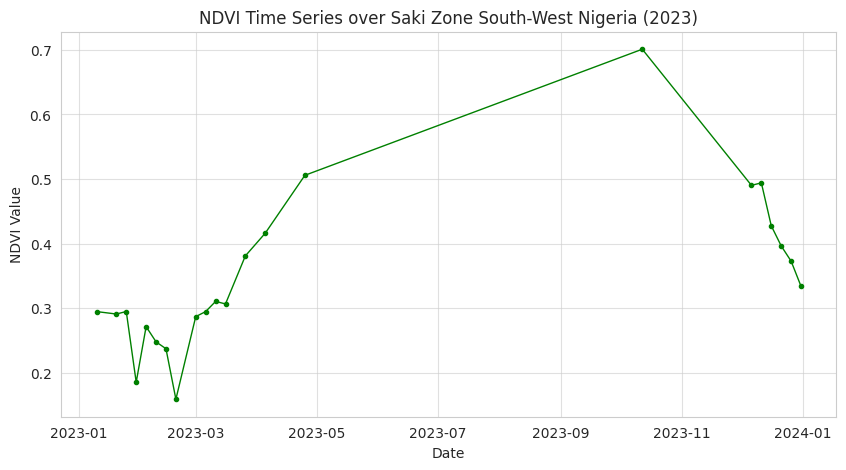

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for better plot visuals
sns.set_style("whitegrid")


def perform_exploratory_data_analysis(df):
    """
    Performs key EDA checks on the structured GEE time series (NDVI),
    identifying trends and seasonality.
    """

    # A. Data Inspection (.head())
    print("\nA. Data Head (First 5 observations):")
    print(df.head())

    # B. Descriptive Statistics (.describe())
    print("\nB. Descriptive Statistics (Distribution Check):")
    print("NDVI should range from -1 (water/built-up) to 1 (dense vegetation).")
    print(df['NDVI_Value'].describe().to_frame().T)

    # C. Time Series Visualization (Conceptual Plot)
    plt.figure(figsize=(10, 5))
    df['NDVI_Value'].plot(
        ax=plt.gca(),
        title='NDVI Time Series over Saki Zone South-West Nigeria (2023)',
        marker='o',
        linestyle='-',
        linewidth=1,
        markersize=3,
        color='green'
    )
    plt.ylabel('NDVI Value')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.6)
    plt.show()



# Execute EDA on the structured data
if 'structured_df' in locals() and not structured_df.empty:
    perform_exploratory_data_analysis(structured_df)
else:
    print("\nCannot perform EDA: GEE data frame is empty or failed to load.")

The distribution of our data represents the full annual cycle of a major agricultural area in Nigeria.<br>
- **Dry Season / Post-Harvest (Min to 25%):**
  - **Minimum (0.1592):** This represents the driest, least productive period (e.g., January/February), when fields are fallow or newly planted.<br>
  - **25th Percentile (0.2880):**  $25\%$ of your observations fall below this value, defining the typical range for the low-growth or dry season months.<br>
- **Average Growth / Derived Savanna (Mean to 50%):**
   - **Median (0.3086):** Half of your observations are below $0.3086$. This is a great representation of the average level of greenness across the entire year, factoring in both dry and wet seasons.<br>
  - **Mean (0.3500):** This is the average NDVI of the farmland across all observed dates.<br>
- **Peak Growth Season (75% to Max):**
  - **Maximum (0.7010):** This value is a strong indicator of high crop productivity. Values above $0.6$ are usually associated with rainforests or fully developed, healthy canopies. This point is your most valuable data for assessing maximum potential yield.

### **Short Literature Search Linking to Research**

The use of satellite is heavily documented in both academic and practitioner literature, focusing on its ability to provide high-frequency, objective measures of economic output.

- **Forecasting Macroeconomic Indicators:** Early academic work demonstrated the viability of using Nighttime Lights data to provide reliable, high-frequency estimates of regional GDP growth, particularly in countries where official data is unreliable or delayed. This work proved that remote sensing data can be a proxy for hard-to-measure economic activity (Sun et al., 2024).

- **Predicting Commodity Prices and Inventory:** A highly cited application is the use of satellite imagery to monitor global oil storage. Analysts track the shadow cast by the floating roofs of crude oil storage tanks to calculate inventory levels. These estimates often precede official government inventory reports, providing a trading advantage in the commodities market (Sagaceta-Mejía et al., 2024).

- **Nowcasting Retail Performance (Car Counts):** Research has shown a statistically significant relationship between daily car counts in the parking lots of major retailers (e.g., Walmart, Costco) and their subsequent quarterly sales figures. By correlating imagery-derived foot traffic with prior earnings releases, hedge funds can nowcast the next quarter's revenue with greater accuracy than consensus estimates.

- **Agricultural Forecasts:** Satellite-derived metrics like NDVI (crop health) and acreage estimation are widely used to predict agricultural yields (e.g., corn, wheat, soybeans), directly impacting the pricing of agricultural futures contracts.
___
**References**

- **Sun et al., 2024.** "Alternative data in finance and business: emerging applications and theory analysis (review).*" Journal of Financial Engineering and Risk Management.*

- **Sagaceta-Mejía et al., 2024.** "An Intelligent Approach for Predicting Stock Market Movements in Emerging Markets Using Optimized Technical Indicators and Neural Networks."

- **Sun-Yunchuan et al., 2022.** "A Survey on Alternative Data in Finance and Business: Emerging Applications and Theory Analysis. https://ssrn.com/abstract=4148628


- **Christina Zhu, 2019.** "Big Data as a Governance Mechanism." *The Review of Financial Studies.* https://www.jstor.org/stable/48568946


